<a href="https://colab.research.google.com/github/dbonekamp/imageProcessingAndR/blob/main/wideLongDemoR_241113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [271]:
import pandas as pd
import numpy as np
from random import randrange

datafilenames = ["patParameter", "patDemographics"]

nsamples = 100
lesPerPat = 5
samples = ['PAT' + f"{i:05d}" + '_LES' + f"{j:02d}" for i in range(1, nsamples+1) for j in range(1, 1+randrange(lesPerPat))]
df = pd.DataFrame({'pseudonym': samples})

num_rows = len(df)
num_benign = num_rows // 2
num_malignant = num_rows - num_benign
labels = ['benign'] * num_benign + ['malignant'] * num_malignant
np.random.shuffle(labels)
df['label'] = labels
effect = [l == "malignant" for l in labels]
parameters = [
    #[direction, mean, std, effectsize]
     [1,  23,  3,  3],
     [-1, 90, 10,  3],
     [1,  73,  3,  0.2],
     [-1, 314, 14,  2],
     [1,  437,  7,  14],
     [-1, 245, 45,  3],
]
for i,p in enumerate(parameters):
  direction = p[0]
  mean = p[1]
  std = p[2]
  effectsize = p[3]
  df[f'parameter_{i}'] = direction * np.array(effect)* effectsize + np.random.normal(loc=0, scale=std, size=len(df)) + mean

!mkdir -p data
df.to_csv(f'data/{datafilenames[0]}.csv', index=False)
df.head()

,pseudonym,label,parameter_0,parameter_1,parameter_2,parameter_3,parameter_4,parameter_5
0,PAT00001_LES01,benign,22.105256,88.802048,76.272735,307.927858,438.318312,302.070369
1,PAT00001_LES02,benign,24.578418,94.502500,66.477810,293.689163,435.063344,187.002590
2,PAT00001_LES03,benign,25.902882,78.017225,72.273210,309.362909,433.443686,213.152302
3,PAT00001_LES04,benign,24.127299,89.999305,75.767683,289.777277,435.519403,239.239636
4,PAT00002_LES01,benign,23.768307,95.836774,70.294613,354.671725,435.435559,243.476961


In [272]:
df3 = df
new_cols = df3['pseudonym'].str.split('_', expand=True)
df3['PAT'] = new_cols[0]
df3['LES'] = new_cols[1]
df3 = df3.drop('pseudonym', axis=1)
df3 = df3[df3.columns.drop(list(df3.filter(regex='parameter_')))]
df3 = df3.rename(columns={"PAT": "pseudonym"})
df3.head()

,label,pseudonym,LES
0,benign,PAT00001,LES01
1,benign,PAT00001,LES02
2,benign,PAT00001,LES03
3,benign,PAT00001,LES04
4,benign,PAT00002,LES01


In [273]:
df4p = df3.pivot(index='pseudonym', columns='LES', values='label')
df4p.head()

LES,LES01,LES02,LES03,LES04
pseudonym,,,,
PAT00001,benign,benign,benign,benign
PAT00002,benign,NaN,NaN,NaN
PAT00003,benign,malignant,NaN,NaN
PAT00004,benign,malignant,malignant,NaN
PAT00005,benign,benign,malignant,malignant


In [274]:
# prompt: create a column "caseLabel" which is "malignant" if at least one of the "LES" columns is "malignant", and "benign" otherwise

df4 = df4p.copy()
df4['caseLabel'] = 'benign'
for col in df4.columns:
  if col != 'caseLabel':
    df4.loc[df4[col] == 'malignant', 'caseLabel'] = 'malignant'
df4 = df4[['caseLabel']]
df4 = df4.reset_index()
df4.head()

LES,pseudonym,caseLabel
0,PAT00001,benign
1,PAT00002,benign
2,PAT00003,malignant
3,PAT00004,malignant
4,PAT00005,malignant


In [275]:
samples = df4['pseudonym'].tolist()
labels = df4['caseLabel'].tolist()
df2 = pd.DataFrame({'pseudonym': samples})

columnNames = ['Age', 'LaboratoryValue_1']

effect = [l == "malignant" for l in labels]
parameters = [
    #[direction, mean, std, effectsize]
     [1,  70,  20,  10],
     [1, 3.0, 2.0,  3],
]
for i,p in enumerate(parameters):
  direction = p[0]
  mean = p[1]
  std = p[2]
  effectsize = p[3]
  df2[f'{columnNames[i]}'] = direction * np.array(effect)* effectsize + np.random.normal(loc=0, scale=std, size=len(df2)) + mean
df2.to_csv(f'data/{datafilenames[1]}.csv', index=False)
df2.head()

,pseudonym,Age,LaboratoryValue_1
0,PAT00001,79.327907,4.459426
1,PAT00002,94.684439,3.967205
2,PAT00003,93.600711,6.923620
3,PAT00004,89.251272,7.691874
4,PAT00005,30.144570,9.480388


In [276]:
%%R
library(tidyverse)

wideData <- read.csv('data/patParameter.csv')

#wideData = wideData %>%
#  column_to_rownames(var = "pseudonym")

head(wideData)

       pseudonym  label parameter_0 parameter_1 parameter_2 parameter_3
1 PAT00001_LES01 benign    22.10526    88.80205    76.27274    307.9279
2 PAT00001_LES02 benign    24.57842    94.50250    66.47781    293.6892
3 PAT00001_LES03 benign    25.90288    78.01722    72.27321    309.3629
4 PAT00001_LES04 benign    24.12730    89.99930    75.76768    289.7773
5 PAT00002_LES01 benign    23.76831    95.83677    70.29461    354.6717
6 PAT00003_LES01 benign    22.16953    81.67795    71.07152    324.6125
  parameter_4 parameter_5
1    438.3183    302.0704
2    435.0633    187.0026
3    433.4437    213.1523
4    435.5194    239.2396
5    435.4356    243.4770
6    425.0589    245.4121


In [277]:
%%R
separatedWideData <- wideData %>%
  separate(col = pseudonym, sep = "_", into = c("pseudonym", "lesion"))

head(separatedWideData)

  pseudonym lesion  label parameter_0 parameter_1 parameter_2 parameter_3
1  PAT00001  LES01 benign    22.10526    88.80205    76.27274    307.9279
2  PAT00001  LES02 benign    24.57842    94.50250    66.47781    293.6892
3  PAT00001  LES03 benign    25.90288    78.01722    72.27321    309.3629
4  PAT00001  LES04 benign    24.12730    89.99930    75.76768    289.7773
5  PAT00002  LES01 benign    23.76831    95.83677    70.29461    354.6717
6  PAT00003  LES01 benign    22.16953    81.67795    71.07152    324.6125
  parameter_4 parameter_5
1    438.3183    302.0704
2    435.0633    187.0026
3    433.4437    213.1523
4    435.5194    239.2396
5    435.4356    243.4770
6    425.0589    245.4121


In [278]:
%%R
longData = separatedWideData %>%
  gather(key = "parameter", value = "value", -label, -pseudonym, -lesion)

sortedLongData = longData %>%
  arrange(pseudonym, lesion, label, parameter)

head(sortedLongData, 20)

   pseudonym lesion  label   parameter     value
1   PAT00001  LES01 benign parameter_0  22.10526
2   PAT00001  LES01 benign parameter_1  88.80205
3   PAT00001  LES01 benign parameter_2  76.27274
4   PAT00001  LES01 benign parameter_3 307.92786
5   PAT00001  LES01 benign parameter_4 438.31831
6   PAT00001  LES01 benign parameter_5 302.07037
7   PAT00001  LES02 benign parameter_0  24.57842
8   PAT00001  LES02 benign parameter_1  94.50250
9   PAT00001  LES02 benign parameter_2  66.47781
10  PAT00001  LES02 benign parameter_3 293.68916
11  PAT00001  LES02 benign parameter_4 435.06334
12  PAT00001  LES02 benign parameter_5 187.00259
13  PAT00001  LES03 benign parameter_0  25.90288
14  PAT00001  LES03 benign parameter_1  78.01722
15  PAT00001  LES03 benign parameter_2  72.27321
16  PAT00001  LES03 benign parameter_3 309.36291
17  PAT00001  LES03 benign parameter_4 433.44369
18  PAT00001  LES03 benign parameter_5 213.15230
19  PAT00001  LES04 benign parameter_0  24.12730
20  PAT00001  LES04 

In [279]:
%%R
wideDataDemographics <- read.csv('data/patDemographics.csv')
head(wideDataDemographics)


  pseudonym      Age LaboratoryValue_1
1  PAT00001 79.32791          4.459426
2  PAT00002 94.68444          3.967205
3  PAT00003 93.60071          6.923620
4  PAT00004 89.25127          7.691874
5  PAT00005 30.14457          9.480388
6  PAT00006 85.05983          5.209061


In [280]:
%%R

fullData <- inner_join(sortedLongData, wideDataDemographics, by = "pseudonym")
head(fullData, 20)

   pseudonym lesion  label   parameter     value      Age LaboratoryValue_1
1   PAT00001  LES01 benign parameter_0  22.10526 79.32791          4.459426
2   PAT00001  LES01 benign parameter_1  88.80205 79.32791          4.459426
3   PAT00001  LES01 benign parameter_2  76.27274 79.32791          4.459426
4   PAT00001  LES01 benign parameter_3 307.92786 79.32791          4.459426
5   PAT00001  LES01 benign parameter_4 438.31831 79.32791          4.459426
6   PAT00001  LES01 benign parameter_5 302.07037 79.32791          4.459426
7   PAT00001  LES02 benign parameter_0  24.57842 79.32791          4.459426
8   PAT00001  LES02 benign parameter_1  94.50250 79.32791          4.459426
9   PAT00001  LES02 benign parameter_2  66.47781 79.32791          4.459426
10  PAT00001  LES02 benign parameter_3 293.68916 79.32791          4.459426
11  PAT00001  LES02 benign parameter_4 435.06334 79.32791          4.459426
12  PAT00001  LES02 benign parameter_5 187.00259 79.32791          4.459426
13  PAT00001

In [281]:
%%R

reshapedFullData <- fullData %>%
  pivot_wider(names_from = parameter, values_from = value)

head(reshapedFullData)

# A tibble: 6 × 11
  pseudonym lesion label    Age LaboratoryValue_1 parameter_0 parameter_1
  <chr>     <chr>  <chr>  <dbl>             <dbl>       <dbl>       <dbl>
1 PAT00001  LES01  benign  79.3              4.46        22.1        88.8
2 PAT00001  LES02  benign  79.3              4.46        24.6        94.5
3 PAT00001  LES03  benign  79.3              4.46        25.9        78.0
4 PAT00001  LES04  benign  79.3              4.46        24.1        90.0
5 PAT00002  LES01  benign  94.7              3.97        23.8        95.8
6 PAT00003  LES01  benign  93.6              6.92        22.2        81.7
# ℹ 4 more variables: parameter_2 <dbl>, parameter_3 <dbl>, parameter_4 <dbl>,
#   parameter_5 <dbl>


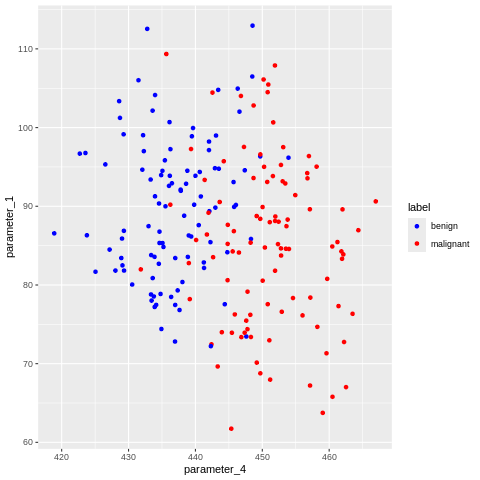

In [282]:
%%R
ggplot(reshapedFullData, aes(x = parameter_4 , y = parameter_1, color = label)) +
  geom_point() +
  labs(x = "parameter_4", y = "parameter_1") +
  scale_color_manual(values = c("blue", "red"))

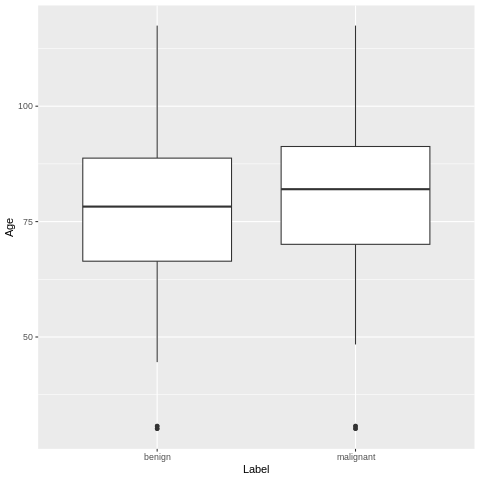

In [283]:
%%R
ggplot(reshapedFullData, aes(x = label, y = Age)) +
  geom_boxplot() +
  labs(x = "Label", y = "Age")